In [36]:
from datasets import load_dataset
ds = load_dataset("m2af/ko-emotion-dataset")

In [37]:

print(ds["train"][0]["annotation"])
print(ds["train"][0])
# ds[["mood_parent","mood_child"]] = ds["mood_code"].str.split("_", n=1, expand=True)

[{'annotator': 'A', 'emotion': '기쁨_만족감', 'gender': 'F'}, {'annotator': 'B', 'emotion': '기쁨_만족감', 'gender': 'M'}, {'annotator': 'C', 'emotion': '기쁨_감동', 'gender': 'F'}, {'annotator': 'E', 'emotion': '기쁨_감동', 'gender': 'F'}, {'annotator': 'D', 'emotion': '기쁨_만족감', 'gender': 'M'}]
{'created_date': '2024-02-03', 'source': 'X', 'context': '보는동안 너무 행복했고 초콜렛이 너무 먹고싶었고 티모시가 잘생겼고 울어!!하는부분이 있어서 울었다네요', 'annotation': "[{'annotator': 'A', 'emotion': '기쁨_만족감', 'gender': 'F'}, {'annotator': 'B', 'emotion': '기쁨_만족감', 'gender': 'M'}, {'annotator': 'C', 'emotion': '기쁨_감동', 'gender': 'F'}, {'annotator': 'E', 'emotion': '기쁨_감동', 'gender': 'F'}, {'annotator': 'D', 'emotion': '기쁨_만족감', 'gender': 'M'}]", '__index_level_0__': 0}


In [38]:
from datasets import DatasetDict

def parse_list_of_dicts(cell):
    # (당신이 올린 것 그대로 사용)
    import ast, json, numpy as np
    if isinstance(cell, list):
        return cell
    if cell is None or (isinstance(cell, float) and np.isnan(cell)):
        return []
    if not isinstance(cell, str) or not cell.strip():
        return []
    s = cell.strip()
    try:
        v = json.loads(s)
        return v if isinstance(v, list) else [v]
    except Exception:
        pass
    try:
        v = ast.literal_eval(s)
        return v if isinstance(v, list) else [v]
    except Exception:
        pass
    s2 = s.replace("None", "null").replace("True", "true").replace("False", "false")
    try:
        v = json.loads(s2)
        return v if isinstance(v, list) else [v]
    except Exception:
        return []

def fix_batch(batch):
    return {
        "annotation_parsed": [parse_list_of_dicts(x) for x in batch["annotation"]]
    }

# splits 전부 처리
for split in ds.keys():  # "train", "validation", "test" 등
    ds[split] = ds[split].map(fix_batch, batched=True)

# 원하면 원본 대체
ds["train"] = ds["train"].remove_columns(["annotation"]).rename_column("annotation_parsed", "annotation")


In [39]:
dataset = []
for data in ds["train"]:
    for annotation in data["annotation"]:
        parent, child = annotation["emotion"].split("_", 1)
        dataset.append({
            "created_date": data["created_date"],
            "source": data["source"],
            "context" : data["context"],
            "annotator" : annotation["annotator"],
            "mood_parent": parent,
            "mood_child": child,
            "gender" : annotation["gender"]
        })

In [40]:

from collections import Counter

cnt = Counter(row.get("mood_parent") for row in dataset)
print(cnt)     

Counter({'기쁨': 1206, '슬픔': 829, '욕망': 596, '싫어함(상태)': 543, '분노': 498, '두려움': 455, '사랑': 435, '미움(상대방)': 411, '수치심': 131, '중립': 91})


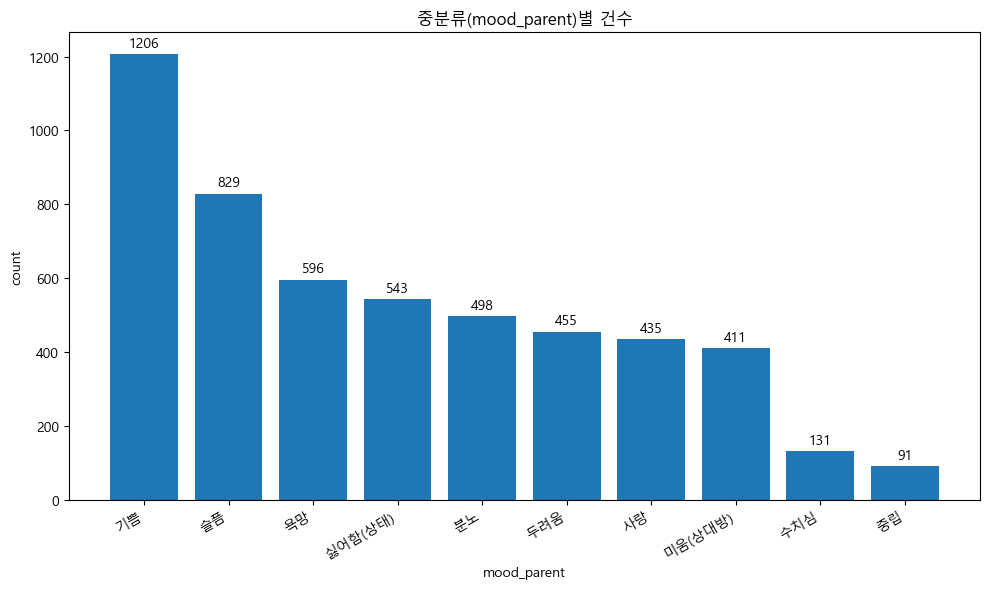

In [41]:

import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams

# ── 한글 폰트 세팅(가능한 것 자동 선택) ──
preferred = ["Malgun Gothic", "AppleGothic", "NanumGothic", "Noto Sans CJK KR", "DejaVu Sans"]
available = {f.name for f in font_manager.fontManager.ttflist}
for fam in preferred:
    if fam in available:
        rcParams["font.family"] = fam
        break
rcParams["axes.unicode_minus"] = False

# ── 정렬 & 그리기 ──
labels, values = zip(*sorted(cnt.items(), key=lambda x: x[1], reverse=True))

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(labels, values)
ax.set_title("중분류(mood_parent)별 건수")
ax.set_xlabel("mood_parent")
ax.set_ylabel("count")
plt.xticks(rotation=30, ha="right")

# 막대 위 숫자 표시
ax.bar_label(bars, fmt="%d", padding=3)

plt.tight_layout()
plt.savefig("mood_parent_counts.png", dpi=200)  # 파일 저장(선택)
plt.show()

In [42]:
# pip install pandas
import pandas as pd

# ① 네가 가진 리스트를 records 변수에 그대로 넣으면 됨
records = dataset  # 위에 붙여넣은 리스트로 대체

# ② DataFrame으로 변환 + 기본 전처리(누락 대비)
df = pd.DataFrame(records)
for col in ["mood_parent", "mood_child"]:
    if col not in df.columns:
        df[col] = None
df["mood_parent"] = df["mood_parent"].fillna("미상")
df["mood_child"]  = df["mood_child"].fillna("미상")

# ③ 중분류 개수
parent_counts = (
    df["mood_parent"]
    .value_counts(dropna=False)
    .rename_axis("mood_parent")
    .reset_index(name="count")
)
parent_counts["pct"] = (parent_counts["count"] / parent_counts["count"].sum() * 100).round(2)

# ④ 소분류 개수(전체 기준)
child_counts = (
    df["mood_child"]
    .value_counts(dropna=False)
    .rename_axis("mood_child")
    .reset_index(name="count")
)
child_counts["pct"] = (child_counts["count"] / child_counts["count"].sum() * 100).round(2)

# ⑤ (중분류, 소분류) 페어 개수 + 중분류 내 비율
pair_counts = (
    df.groupby(["mood_parent", "mood_child"], dropna=False)
      .size()
      .reset_index(name="count")
      .sort_values(["mood_parent", "count"], ascending=[True, False])
)
pair_counts["parent_total"] = pair_counts.groupby("mood_parent")["count"].transform("sum")
pair_counts["pct_within_parent"] = (pair_counts["count"] / pair_counts["parent_total"] * 100).round(2)

# ⑥ 피벗(행=중분류, 열=소분류, 값=건수)
pivot = pair_counts.pivot_table(index="mood_parent", columns="mood_child", values="count", fill_value=0)

# ── 결과 확인(상위만 프린트)
print("\n[중분류 개수]")
print(parent_counts.head(20).to_string(index=False))

print("\n[소분류 개수]")
print(child_counts.head(20).to_string(index=False))

print("\n[(중분류, 소분류) 페어 상위 20]")
print(pair_counts.head(20).to_string(index=False))

# 필요하면 파일 저장
parent_counts.to_csv("parent_counts.csv", index=False, encoding="utf-8-sig")
child_counts.to_csv("child_counts.csv", index=False, encoding="utf-8-sig")
pair_counts.to_csv("pair_counts.csv", index=False, encoding="utf-8-sig")
pivot.to_csv("pair_pivot.csv", encoding="utf-8-sig")



[중분류 개수]
mood_parent  count   pct
         기쁨   1206 23.21
         슬픔    829 15.96
         욕망    596 11.47
    싫어함(상태)    543 10.45
         분노    498  9.59
        두려움    455  8.76
         사랑    435  8.37
    미움(상대방)    411  7.91
        수치심    131  2.52
         중립     91  1.75

[소분류 개수]
mood_child  count  pct
       만족감    305 5.87
       아쉬움    231 4.45
        놀람    223 4.29
        감동    221 4.25
        불쾌    195 3.75
        걱정    167 3.21
       답답함    164 3.16
    동정(슬픔)    159 3.06
       즐거움    153 2.95
        불만    146 2.81
        경멸    127 2.44
       고마움    119 2.29
       난처함    113 2.18
        욕심    113 2.18
       기대감    109 2.10
        실망    105 2.02
       무기력     98 1.89
        공포     96 1.85
     자랑스러움     94 1.81
       불편함     93 1.79

[(중분류, 소분류) 페어 상위 20]
mood_parent mood_child  count  parent_total  pct_within_parent
         기쁨        만족감    295          1206              24.46
         기쁨         감동    195          1206              16.17
         기

In [43]:
import pandas as pd
import numpy as np
from itertools import chain

# 1) 도큐(표)에 있는 합법 라벨 맵
ALLOWED = {
    "기쁨": ["반가움","통쾌함","즐거움","신명남","자신감","감동","만족감","편안함","고마움","신뢰감","안정감","공감","자랑스러움"],
    "사랑": ["호감","귀중함","매력적","두근거림","아른거림","너그러움","열정적임","다정함","동정(슬픔)"],
    "슬픔": ["억울함","외로움","후회","실망","허망","그리움","수치심","고통","절망","무기력","아픔"],
    "두려움": ["위축감","놀람","공포","걱정","초조함"],
    "분노": ["원망","불쾌","사나움","날카로움","타오름"],
    "미움(상대방)": ["반감","경멸","비위상함","치사함","불신감","시기심","외면","냉담"],
    "욕망": ["욕심","궁금함","아쉬움","불만","갈등","기대감"],
    "싫어함(상태)": ["답답함","불편함","난처함","서먹함","심심함","싫증"],
    "수치심": ["부끄러움","죄책감","미안함"],
}
ALLOWED_PARENTS   = set(ALLOWED.keys())
ALLOWED_CHILDREN  = set(chain.from_iterable(ALLOWED.values()))
ALLOWED_PAIRS     = {(p,c) for p,chs in ALLOWED.items() for c in chs}

# 2) 너의 데이터 로딩 (list[dict] 또는 DataFrame 아무거나 OK)
records = dataset
df = pd.DataFrame(records)

# 결측 대비
for col in ["mood_parent","mood_child"]:
    if col not in df.columns:
        df[col] = None

# 3) 도큐에 "없는" 라벨 판별 사유(reason) 만들기
def reason_row(r):
    p, c = r["mood_parent"], r["mood_child"]
    if p not in ALLOWED_PARENTS:
        return "unknown_parent"                 # 예: '중립'
    if (p, c) not in ALLOWED_PAIRS:
        # 소분류 자체가 표에 없을 수도(예: '발열'), 또는 부모-자식 불일치
        return "child_unknown_or_mismatch"
    return "ok"

df["reason"] = df[["mood_parent","mood_child"]].apply(reason_row, axis=1)

# 4) 불일치 라벨만 집계 → 25 미만만 보기
INVALID = df[df["reason"] != "ok"]

counts = (INVALID
          .groupby(["mood_parent","mood_child","reason"], dropna=False)
          .size()
          .reset_index(name="count")
          .sort_values("count", ascending=False))

under_25 = counts[counts["count"] < 25] \
             .sort_values(["count","mood_parent","mood_child"], ascending=[True, True, True])

print("\n[도큐에 없는 라벨 중 25건 미만]")
print(under_25.to_string(index=False))

# 5) (옵션) 사유별로도 보고 싶다면:
by_reason = (under_25.groupby("reason")["count"].sum()
             .reset_index()
             .sort_values("count", ascending=False))
print("\n[사유별 합계(25 미만에 한정)]")
print(by_reason.to_string(index=False))
import pandas as pd
import numpy as np
from itertools import chain

# 1) 도큐(표)에 있는 합법 라벨 맵
ALLOWED = {
    "기쁨": ["반가움","통쾌함","즐거움","신명남","자신감","감동","만족감","편안함","고마움","신뢰감","안정감","공감","자랑스러움"],
    "사랑": ["호감","귀중함","매력적","두근거림","아른거림","너그러움","열정적임","다정함","동정(슬픔)"],
    "슬픔": ["억울함","외로움","후회","실망","허망","그리움","수치심","고통","절망","무기력","아픔"],
    "두려움": ["위축감","놀람","공포","걱정","초조함"],
    "분노": ["원망","불쾌","사나움","날카로움","타오름"],
    "미움(상대방)": ["반감","경멸","비위상함","치사함","불신감","시기심","외면","냉담"],
    "욕망": ["욕심","궁금함","아쉬움","불만","갈등","기대감"],
    "싫어함(상태)": ["답답함","불편함","난처함","서먹함","심심함","싫증"],
    "수치심": ["부끄러움","죄책감","미안함"],
}
ALLOWED_PARENTS   = set(ALLOWED.keys())
ALLOWED_CHILDREN  = set(chain.from_iterable(ALLOWED.values()))
ALLOWED_PAIRS     = {(p,c) for p,chs in ALLOWED.items() for c in chs}

# 2) 너의 데이터 로딩 (list[dict] 또는 DataFrame 아무거나 OK)
# records = [...]  # ← 네 리스트 그대로 넣기
df = pd.DataFrame(records)

# 결측 대비
for col in ["mood_parent","mood_child"]:
    if col not in df.columns:
        df[col] = None

# 3) 도큐에 "없는" 라벨 판별 사유(reason) 만들기
def reason_row(r):
    p, c = r["mood_parent"], r["mood_child"]
    if p != "중립":
        if p not in ALLOWED_PARENTS:
            return "unknown_parent"                 # 예: '중립'
        if (p, c) not in ALLOWED_PAIRS:
            # 소분류 자체가 표에 없을 수도(예: '발열'), 또는 부모-자식 불일치
            return "child_unknown_or_mismatch"
    return "ok"

df["reason"] = df[["mood_parent","mood_child"]].apply(reason_row, axis=1)

# 4) 불일치 라벨만 집계 → 25 미만만 보기
INVALID = df[df["reason"] != "ok"]

counts = (INVALID
          .groupby(["mood_parent","mood_child","reason"], dropna=False)
          .size()
          .reset_index(name="count")
          .sort_values("count", ascending=False))

under_25 = counts[counts["count"] < 25] \
             .sort_values(["count","mood_parent","mood_child"], ascending=[True, True, True])

print("\n[도큐에 없는 라벨 중 25건 미만]")
print(under_25.to_string(index=False))

# 5) (옵션) 사유별로도 보고 싶다면:
by_reason = (under_25.groupby("reason")["count"].sum()
             .reset_index()
             .sort_values("count", ascending=False))
print("\n[사유별 합계(25 미만에 한정)]")
print(by_reason.to_string(index=False))



[도큐에 없는 라벨 중 25건 미만]
mood_parent mood_child                    reason  count
         기쁨        귀중함 child_unknown_or_mismatch      1
         기쁨       아른거림 child_unknown_or_mismatch      1
         기쁨         호감 child_unknown_or_mismatch      1
        두려움        궁금함 child_unknown_or_mismatch      1
        두려움        난처함 child_unknown_or_mismatch      1
        두려움       날카로움 child_unknown_or_mismatch      1
        두려움        만족감 child_unknown_or_mismatch      1
        두려움       부끄러움 child_unknown_or_mismatch      1
        두려움        불신감 child_unknown_or_mismatch      1
        두려움        외로움 child_unknown_or_mismatch      1
        두려움         절망 child_unknown_or_mismatch      1
    미움(상대방)       날카로움 child_unknown_or_mismatch      1
    미움(상대방)         놀람 child_unknown_or_mismatch      1
    미움(상대방)        답답함 child_unknown_or_mismatch      1
    미움(상대방)        불편함 child_unknown_or_mismatch      1
    미움(상대방)         아픔 child_unknown_or_mismatch      1
    미움(상대방)         원망 chi

In [44]:
# 1) 지울 페어 집합 만들기
drop_pairs = set(zip(under_25["mood_parent"], under_25["mood_child"]))

# 2) 원본에 페어 컬럼 만들고 필터
_ = df.assign(pair=list(zip(df["mood_parent"], df["mood_child"])))
df_clean = _.loc[~_.pair.isin(drop_pairs)].drop(columns="pair").reset_index(drop=True)

print(df.shape, "→", df_clean.shape)

(5195, 8) → (4859, 8)


In [45]:
# 타입/공백 정리(권장)
df["mood_parent"] = df["mood_parent"].astype("string").str.strip()
df["mood_child"]  = df["mood_child"].astype("string").str.strip()

# 1) 부모/자식 ‘종류’ 리스트
parents = sorted(df["mood_parent"].dropna().unique().tolist())
children = sorted(df["mood_child"].dropna().unique().tolist())

print("부모 종류 수:", len(parents))
print(parents)
print("자식 종류 수:", len(children))
print(children)

# 2) 부모/자식 각각의 개수(몇 건씩 있는지)
parent_counts = df["mood_parent"].value_counts().sort_index()
child_counts  = df["mood_child"].value_counts().sort_index()

print(parent_counts)
print(child_counts)

# 3) (부모, 자식) 페어의 ‘종류’와 개수
pair_counts = (
    df.groupby(["mood_parent", "mood_child"])
      .size()
      .rename("count")
      .sort_values(ascending=False)
)
print(pair_counts)

# 4) 부모별로 어떤 자식들이 있는지 “맵”으로 보기
parent2children = (
    df.groupby("mood_parent")["mood_child"]
      .apply(lambda s: sorted(s.dropna().unique().tolist()))
      .to_dict()
)
for p, chs in parent2children.items():
    print(f"{p} -> {', '.join(chs)}")

# (선택) CSV로 내보내기
pd.Series(parents, name="mood_parent_unique").to_csv("parents_unique.csv", index=False, encoding="utf-8-sig")
pd.Series(children, name="mood_child_unique").to_csv("children_unique.csv", index=False, encoding="utf-8-sig")
pair_counts.reset_index().to_csv("pair_counts.csv", index=False, encoding="utf-8-sig")


부모 종류 수: 10
['기쁨', '두려움', '미움(상대방)', '분노', '사랑', '수치심', '슬픔', '싫어함(상태)', '욕망', '중립']
자식 종류 수: 67
['갈등', '감동', '걱정', '경멸', '고마움', '고통', '공감', '공포', '궁금함', '귀중함', '그리움', '기대감', '난처함', '날카로움', '냉담', '너그러움', '놀람', '다정함', '답답함', '동정(슬픔)', '두근거림', '만족감', '매력적', '무기력', '미안함', '반가움', '반감', '발열', '부끄러움', '불만', '불신감', '불쾌', '불편함', '비위상함', '사나움', '서먹함', '수치심', '시기심', '신뢰감', '신명남', '실망', '싫증', '심심함', '아른거림', '아쉬움', '아픔', '안정감', '억울함', '열정적인', '외로움', '외면', '욕심', '원망', '위축감', '자랑스러움', '자신감', '절망', '죄책감', '즐거움', '초조함', '치사함', '타오름', '통쾌함', '편안함', '허망', '호감', '후회']
mood_parent
기쁨         1206
두려움         455
미움(상대방)     411
분노          498
사랑          435
수치심         131
슬픔          829
싫어함(상태)     543
욕망          596
중립           91
Name: count, dtype: Int64
mood_child
갈등      14
감동     221
걱정     167
경멸     127
고마움    119
      ... 
통쾌함     28
편안함     35
허망      90
호감      83
후회      54
Name: count, Length: 67, dtype: Int64
mood_parent  mood_child
기쁨           만족감           295
욕망           아쉬움     

In [48]:
# 0) 전처리
df["mood_parent"] = df["mood_parent"].astype("string").str.strip()
df["mood_child"]  = df["mood_child"].astype("string").str.strip()

# 1) 도큐 기준(필요시 수정)
doc_map = {
    "기쁨": ["반가움","즐거움","신명남","자신감","감동","만족감","편안함","고마움","신뢰감","안정감","공감","자랑스러움"],
    "사랑": ["호감","귀중함","매력적","두근거림","아른거림","너그러움","열정적임","다정함","동정(슬픔)"],
    "슬픔": ["억울함","외로움","후회","실망","허망","그리움","수치심","고통","절망","무기력","아픔"],
    "두려움": ["위축감","놀람","공포","걱정","초조함"],
    "분노": ["원망","불쾌","날카로움","타오름"],
    "미움(상대방)": ["반감","경멸","비위상함","치사함","불신감","시기심","외면","냉담"],
    "욕망": ["욕심","궁금함","아쉬움","불만","갈등","기대감"],
    "싫어함(상태)": ["답답함","불편함","난처함","서먹함","심심함","싫증"],
    "수치심": ["부끄러움","죄책감","미안함"],
    "중립": []
}

# 2) (부모,자식) 조합 빈도 + 유지/제외 플래그
pair_counts = df.groupby(["mood_parent","mood_child"]).size().rename("count").reset_index()
pair_counts["in_doc"] = pair_counts.apply(
    lambda r: r["mood_child"] in set(doc_map.get(r["mood_parent"], [])),
    axis=1
)
pair_counts["keep"] = False
pair_counts.loc[pair_counts["in_doc"], "keep"] = True
pair_counts.loc[~pair_counts["in_doc"] & (pair_counts["count"] >= 25), "keep"] = True

# 3) “종류(유형)”만 보기 ─ 고유 리스트
# 3-1) 살릴 조합의 고유 부모/자식/페어
pair_counts = (
    df.groupby(["mood_parent","mood_child"])
      .size().rename("count").reset_index()
)

# 도큐 일치 여부
pair_counts["in_doc"] = pair_counts.apply(
    lambda r: r["mood_child"] in set(doc_map.get(r["mood_parent"], [])),
    axis=1
)

# 기본 규칙: 도큐 일치 or (도큐 밖이지만 25건 이상)
pair_counts["keep"] = False
pair_counts.loc[pair_counts["in_doc"], "keep"] = True
pair_counts.loc[~pair_counts["in_doc"] & (pair_counts["count"] >= 25), "keep"] = True

# ✅ 추가 규칙: '중립'은 전부 살리기
pair_counts.loc[pair_counts["mood_parent"].eq("중립"), "keep"] = True

# 살릴 (부모,자식) 종류
kept_pairs_df = pair_counts.loc[pair_counts["keep"], ["mood_parent","mood_child"]].drop_duplicates()

# 원본 df 필터링: kept pair 이거나, 부모가 '중립'이면 유지
df_kept = (
    df.merge(kept_pairs_df.assign(_keep=1), on=["mood_parent","mood_child"], how="left")
      .loc[lambda x: x["_keep"].eq(1) | x["mood_parent"].eq("중립")]
      .drop(columns="_keep")
      .reset_index(drop=True)
)

# (선택) 종류만 보기
kept_parents  = sorted(df_kept["mood_parent"].unique().tolist())
kept_children = sorted(df_kept["mood_child"].unique().tolist())
kept_pairs    = (
    df_kept[["mood_parent","mood_child"]]
    .drop_duplicates()
    .sort_values(["mood_parent","mood_child"])
    .values.tolist()
)

print("✅ 살릴 부모(종류):", len(kept_parents), kept_parents)
print("✅ 살릴 자식(종류):", len(kept_children), kept_children)
print("✅ 살릴 (부모,자식) 페어(종류):", kept_pairs)

✅ 살릴 부모(종류): 10 ['기쁨', '두려움', '미움(상대방)', '분노', '사랑', '수치심', '슬픔', '싫어함(상태)', '욕망', '중립']
✅ 살릴 자식(종류): 67 ['갈등', '감동', '걱정', '경멸', '고마움', '고통', '공감', '공포', '궁금함', '귀중함', '그리움', '기대감', '난처함', '날카로움', '냉담', '너그러움', '놀람', '다정함', '답답함', '동정(슬픔)', '두근거림', '만족감', '매력적', '무기력', '미안함', '반가움', '반감', '발열', '부끄러움', '불만', '불신감', '불쾌', '불편함', '비위상함', '사나움', '서먹함', '수치심', '시기심', '신뢰감', '신명남', '실망', '싫증', '심심함', '아른거림', '아쉬움', '아픔', '안정감', '억울함', '열정적인', '외로움', '외면', '욕심', '원망', '위축감', '자랑스러움', '자신감', '절망', '죄책감', '즐거움', '초조함', '치사함', '타오름', '통쾌함', '편안함', '허망', '호감', '후회']
✅ 살릴 (부모,자식) 페어(종류): [['기쁨', '감동'], ['기쁨', '고마움'], ['기쁨', '공감'], ['기쁨', '기대감'], ['기쁨', '놀람'], ['기쁨', '만족감'], ['기쁨', '반가움'], ['기쁨', '신뢰감'], ['기쁨', '신명남'], ['기쁨', '안정감'], ['기쁨', '자랑스러움'], ['기쁨', '자신감'], ['기쁨', '즐거움'], ['기쁨', '통쾌함'], ['기쁨', '편안함'], ['두려움', '걱정'], ['두려움', '공포'], ['두려움', '놀람'], ['두려움', '위축감'], ['두려움', '초조함'], ['미움(상대방)', '경멸'], ['미움(상대방)', '냉담'], ['미움(상대방)', '반감'], ['미움(상대방)', '불신감'], ['미움(상대방)', '비위상함'], ['미움(상대방)', '시기

    mood_parent mood_child  count
96           중립      자랑스러움      1
97           중립         절망      1
82           중립        답답함      1
95           중립        위축감      1
93           중립       열정적인      1
91           중립        신뢰감      1
89           중립         불쾌      1
88           중립        불신감      1
94           중립        외로움      1
87           중립        반가움      1
86           중립        미안함      1
77           중립        그리움      1
100          중립         호감      1
101          중립         후회      1
98           중립        통쾌함      1
99           중립        편안함      1
74           중립         공포      1
76           중립        귀중함      1
69           중립         감동      1
70           중립         걱정      1
72           중립         고통      2
71           중립        고마움      2
85           중립        무기력      2
78           중립        난처함      2
79           중립         냉담      2
90           중립        서먹함      2
75           중립        궁금함      2
92           중립        안정감      3
81           중

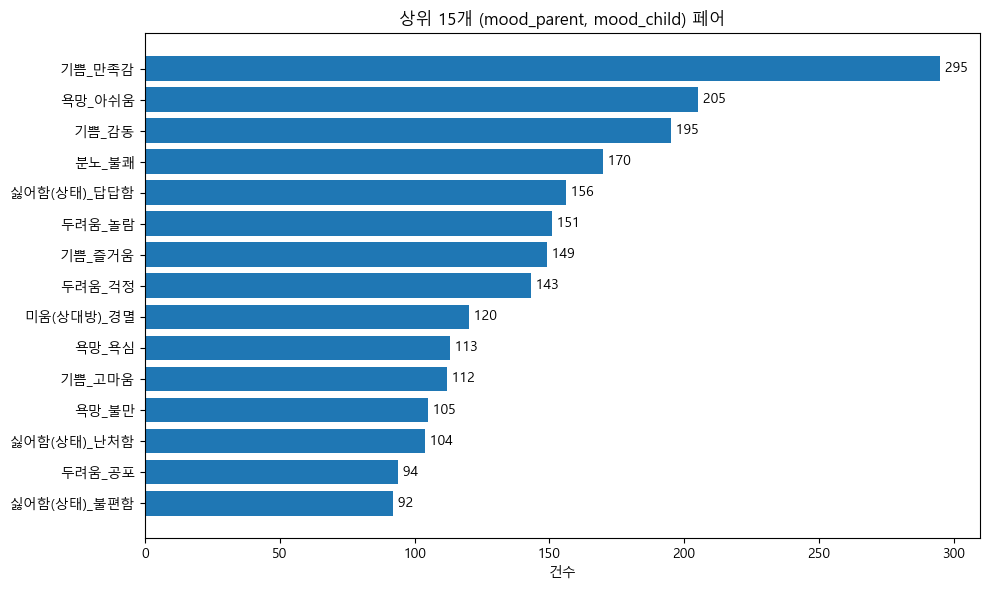

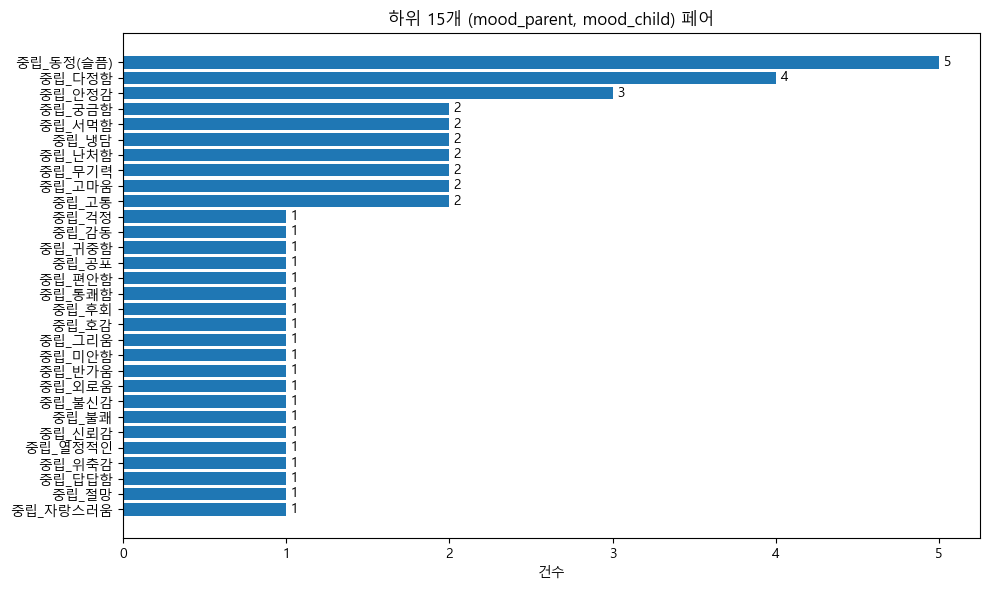


[상위 15개]
    mood_parent mood_child  count        label
0           기쁨        만족감    295       기쁨_만족감
1           욕망        아쉬움    205       욕망_아쉬움
2           기쁨         감동    195        기쁨_감동
3           분노         불쾌    170        분노_불쾌
4      싫어함(상태)        답답함    156  싫어함(상태)_답답함
5          두려움         놀람    151       두려움_놀람
6           기쁨        즐거움    149       기쁨_즐거움
7          두려움         걱정    143       두려움_걱정
8      미움(상대방)         경멸    120   미움(상대방)_경멸
9           욕망         욕심    113        욕망_욕심
10          기쁨        고마움    112       기쁨_고마움
11          욕망         불만    105        욕망_불만
12     싫어함(상태)        난처함    104  싫어함(상태)_난처함
13         두려움         공포     94       두려움_공포
14     싫어함(상태)        불편함     92  싫어함(상태)_불편함

[하위 15개]
    mood_parent mood_child  count      label
0           중립      자랑스러움      1   중립_자랑스러움
1           중립         절망      1      중립_절망
2           중립        답답함      1     중립_답답함
3           중립        위축감      1     중립_위축감
4           중립       열

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) (부모, 자식) 페어 개수 집계
pair_cnt = (
    df_kept.groupby(["mood_parent", "mood_child"])
           .size().rename("count").reset_index()
)

# 2) 상위 / 하위 15개 선택
top15 = pair_cnt.sort_values("count", ascending=False).head(15)
bot15 = pair_cnt.sort_values("count", ascending=True).head(30)
print(bot15)
# 라벨: 부모_자식 (자식이 결측/빈문자면 부모만 표기)
def mk_label(row):
    ch = "" if pd.isna(row["mood_child"]) else str(row["mood_child"]).strip()
    return f'{row["mood_parent"]}_{ch}' if ch else f'{row["mood_parent"]}'

top15 = top15.assign(label=top15.apply(mk_label, axis=1))
bot15 = bot15.assign(label=bot15.apply(mk_label, axis=1))

# 3) 상위 15 (큰 값이 위로 오도록 정렬)
tplot = top15.sort_values("count", ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(tplot["label"], tplot["count"])
plt.title("상위 15개 (mood_parent, mood_child) 페어")
plt.xlabel("건수")
plt.tight_layout()
# 막대 끝에 수치 찍기
for i, v in enumerate(tplot["count"].values):
    plt.text(v, i, f" {v}", va="center")
plt.show()

# 4) 하위 15 (작은 값이 위로 오도록 정렬)
bplot = bot15.sort_values("count", ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(bplot["label"], bplot["count"])
plt.title("하위 15개 (mood_parent, mood_child) 페어")
plt.xlabel("건수")
plt.tight_layout()
for i, v in enumerate(bplot["count"].values):
    plt.text(v, i, f" {v}", va="center")
plt.show()

# (선택) 확인용 표 출력
print("\n[상위 15개]\n", top15.sort_values("count", ascending=False).reset_index(drop=True))
print("\n[하위 15개]\n", bot15.sort_values("count", ascending=True).reset_index(drop=True))
